# F1 Integrated Driver Evaluation System

This notebook integrates the driver evaluation system with the fixed prediction models to create a unified system for Prize Picks optimization.

## Key Integration Points:
1. **Age-Performance Curves**: Adjust predictions based on driver development phase
2. **Constructor Compatibility**: Factor team dynamics into race predictions
3. **Consistency Metrics**: Weight predictions by driver reliability
4. **Long-term Value**: Identify betting opportunities based on driver trajectories

In [1]:
# Define module exports - this will be populated after the class is defined
__all__ = []

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
from datetime import datetime, timedelta
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
# plt.style.use('seaborn-darkgrid') # Original style - may not work on all systems
# Safe plotting style setup
try:
    import seaborn as sns
    sns.set_theme()  # Modern seaborn initialization
except:
    try:
        plt.style.use('ggplot')  # Fallback style
    except:
        pass  # Use default style
sns.set_palette('husl')

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Setup imports with robust path handling
import sys
import os
from pathlib import Path

# Determine the notebook location and add necessary paths
try:
    # In Jupyter notebooks, __file__ might not be defined
    notebook_dir = Path.cwd()
    
    # Check if we're in the advanced directory
    if 'advanced' in str(notebook_dir):
        # We're in the advanced directory
        if str(notebook_dir) not in sys.path:
            sys.path.insert(0, str(notebook_dir))
    else:
        # Add the advanced directory to path
        workspace_root = notebook_dir
        
        # Navigate to find the advanced directory
        possible_paths = [
            notebook_dir / 'notebooks' / 'advanced',  # From workspace root
            notebook_dir / 'advanced',  # From notebooks directory
            notebook_dir.parent / 'advanced',  # If we're in a sibling directory
            notebook_dir.parent / 'notebooks' / 'advanced',  # From other locations
        ]
        
        for path in possible_paths:
            if path.exists() and str(path) not in sys.path:
                sys.path.insert(0, str(path))
                break
                
except Exception as e:
    print(f"Path setup warning: {e}")
    # Fallback to simple path addition
    sys.path.append('.')
from f1db_data_loader import load_f1db_data, F1DBDataLoader


## 1. Load and Prepare Integrated Dataset

In [4]:
# Merge core data with driver information
df = results.merge(races[['raceId', 'year', 'round', 'circuitId', 'date']], on='raceId')
df = df.merge(drivers[['driverId', 'driverRef', 'surname', 'dob', 'nationality']], on='driverId')
df = df.merge(constructors[['constructorId', 'constructorRef', 'name']], 
              on='constructorId', suffixes=('_race', '_constructor'))

# Calculate driver age at race time
df['date'] = pd.to_datetime(df['date'])
df['dob'] = pd.to_datetime(df['dob'])
df['driver_age'] = (df['date'] - df['dob']).dt.days / 365.25

# Sort chronologically
df = df.sort_values(['date', 'raceId'])

print(f"Combined dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Combined dataset shape: (26399, 29)
Date range: 1950-05-13 00:00:00 to 2024-05-05 00:00:00


## 2. Driver Evaluation Metrics

In [5]:
def calculate_enhanced_driver_metrics(df):
    """
    Calculate comprehensive driver metrics including evaluation scores
    """
    metrics = []
    
    # Focus on recent seasons for relevance
    recent_df = df[df['year'] >= 2019].copy()
    
    for driver_id in recent_df['driverId'].unique():
        driver_data = recent_df[recent_df['driverId'] == driver_id]
        
        # Basic information
        driver_info = {
            'driverId': driver_id,
            'driverRef': driver_data['driverRef'].iloc[0],
            'surname': driver_data['surname'].iloc[0],
            'current_age': driver_data['driver_age'].iloc[-1] if len(driver_data) > 0 else 0,
            'races_completed': len(driver_data),
            'years_active': driver_data['year'].nunique()
        }
        
        # Performance metrics
        driver_info['avg_position'] = driver_data['positionOrder'].mean()
        driver_info['avg_points'] = driver_data['points'].mean()
        driver_info['total_points'] = driver_data['points'].sum()
        driver_info['podium_rate'] = (driver_data['positionOrder'] <= 3).mean()
        driver_info['top10_rate'] = (driver_data['positionOrder'] <= 10).mean()
        driver_info['dnf_rate'] = (driver_data['statusId'] > 1).mean()
        driver_info['wins'] = (driver_data['positionOrder'] == 1).sum()
        driver_info['win_rate'] = (driver_data['positionOrder'] == 1).mean()
        
        # Consistency metrics
        driver_info['position_std'] = driver_data['positionOrder'].std()
        driver_info['points_std'] = driver_data['points'].std()
        driver_info['consistency_score'] = 1 / (1 + driver_info['position_std']) if driver_info['position_std'] > 0 else 1
        
        # Recent form (last 10 races)
        recent_races = driver_data.sort_values('date').tail(10)
        if len(recent_races) > 0:
            driver_info['recent_avg_position'] = recent_races['positionOrder'].mean()
            driver_info['recent_avg_points'] = recent_races['points'].mean()
            driver_info['recent_form_trend'] = driver_info['avg_position'] - driver_info['recent_avg_position']
        else:
            driver_info['recent_avg_position'] = driver_info['avg_position']
            driver_info['recent_avg_points'] = driver_info['avg_points']
            driver_info['recent_form_trend'] = 0
        
        # Track diversity
        driver_info['track_diversity'] = driver_data['circuitId'].nunique()
        driver_info['avg_tracks_per_season'] = driver_info['track_diversity'] / max(1, driver_info['years_active'])
        
        # Constructor performance
        current_constructor = driver_data['constructorId'].iloc[-1] if len(driver_data) > 0 else None
        driver_info['current_constructor'] = current_constructor
        driver_info['constructor_changes'] = driver_data['constructorId'].nunique()
        
        metrics.append(driver_info)
    
    return pd.DataFrame(metrics)

# Calculate driver metrics
driver_metrics = calculate_enhanced_driver_metrics(df)
print(f"\nCalculated metrics for {len(driver_metrics)} drivers")
print("\nTop 10 drivers by average points:")
print(driver_metrics.nlargest(10, 'avg_points')[['surname', 'avg_points', 'consistency_score', 'current_age']].round(2))


Calculated metrics for 34 drivers

Top 10 drivers by average points:
       surname  avg_points  consistency_score  current_age
2   Verstappen       17.85               0.15        26.60
1     Hamilton       14.82               0.18        39.32
4      Leclerc        9.85               0.14        26.55
12       Pérez        9.34               0.15        34.27
19       Sainz        7.76               0.15        29.68
0       Bottas        7.50               0.14        34.69
11      Norris        6.24               0.17        24.48
33     Bearman        6.00               1.00        18.84
26      Alonso        5.46               0.17        42.77
3       Vettel        4.41               0.16        35.38


## 3. Age-Performance Modeling

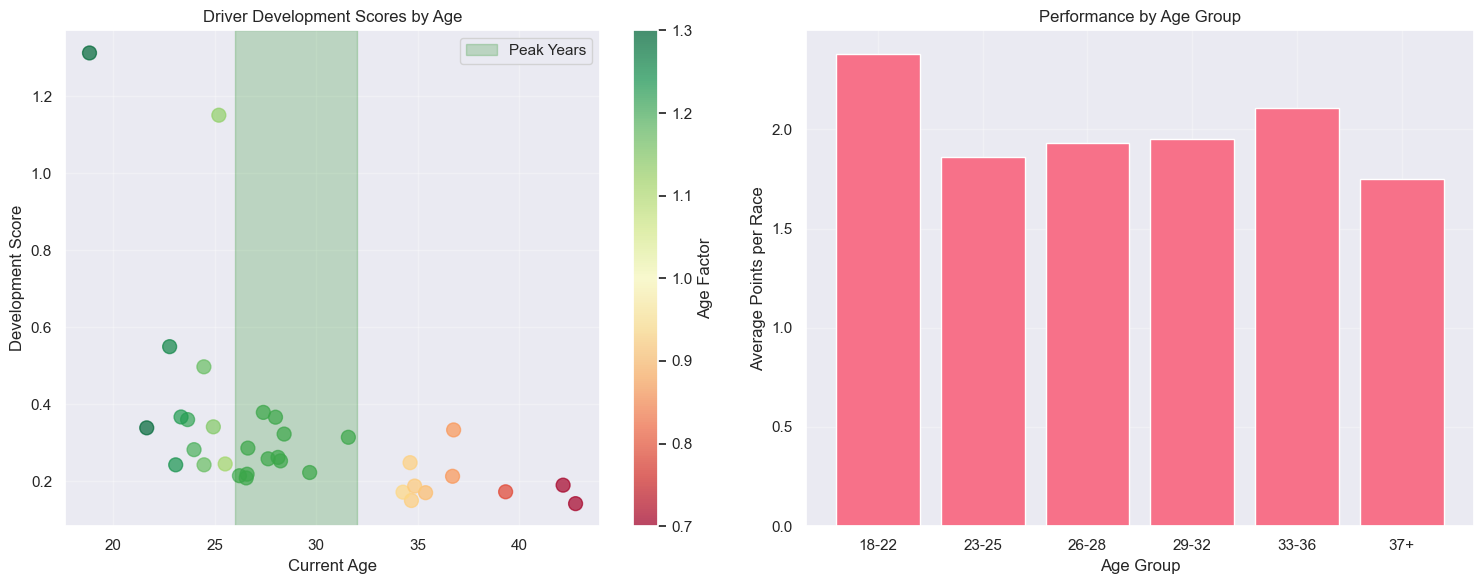


Age Group Performance Summary:
          positionOrder       points       driverId
                   mean   std   mean   std  nunique
age_group                                          
18-22             12.56  6.14   2.38  4.77       56
23-25             13.25  7.02   1.86  4.37      204
26-28             13.01  7.69   1.93  4.26      320
29-32             13.09  8.03   1.95  4.41      385
33-36             12.18  7.81   2.11  4.37      300
37+               12.56  7.68   1.75  3.69      255


In [6]:
def create_age_performance_model(df, driver_metrics):
    """
    Model the relationship between age and performance
    """
    # Create age bins for analysis
    age_bins = [18, 22, 25, 28, 32, 36, 45]
    age_labels = ['18-22', '23-25', '26-28', '29-32', '33-36', '37+']
    
    df['age_group'] = pd.cut(df['driver_age'], bins=age_bins, labels=age_labels, include_lowest=True)
    
    # Calculate performance by age group
    age_performance = df.groupby('age_group').agg({
        'positionOrder': ['mean', 'std'],
        'points': ['mean', 'std'],
        'driverId': 'nunique'
    }).round(2)
    
    # Peak performance window
    peak_age_range = (26, 32)
    
    # Calculate development scores
    development_scores = []
    
    for _, driver in driver_metrics.iterrows():
        age = driver['current_age']
        
        # Development phase
        if age < peak_age_range[0]:
            development_phase = 'pre-peak'
            years_to_peak = peak_age_range[0] - age
            # Young drivers have high potential
            age_factor = 1.1 + (0.05 * min(years_to_peak, 4))
        elif age <= peak_age_range[1]:
            development_phase = 'peak'
            years_to_peak = 0
            age_factor = 1.2  # Peak performance
        else:
            development_phase = 'post-peak'
            years_past_peak = age - peak_age_range[1]
            # Gradual decline
            age_factor = 1.0 - (0.03 * min(years_past_peak, 10))
        
        # Experience bonus
        experience_factor = min(1.2, 1 + (driver['races_completed'] / 100))
        
        # Combined development score
        development_score = age_factor * experience_factor * driver['consistency_score']
        
        development_scores.append({
            'driverId': driver['driverId'],
            'surname': driver['surname'],
            'current_age': age,
            'development_phase': development_phase,
            'age_factor': age_factor,
            'experience_factor': experience_factor,
            'development_score': development_score
        })
    
    development_df = pd.DataFrame(development_scores)
    
    # Visualize age-performance relationship
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Age distribution with performance
    scatter = ax1.scatter(development_df['current_age'], 
                         development_df['development_score'],
                         c=development_df['age_factor'], 
                         cmap='RdYlGn', s=100, alpha=0.7)
    
    # Add peak performance zone
    ax1.axvspan(peak_age_range[0], peak_age_range[1], alpha=0.2, color='green', label='Peak Years')
    
    ax1.set_xlabel('Current Age')
    ax1.set_ylabel('Development Score')
    ax1.set_title('Driver Development Scores by Age')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Age Factor')
    
    # Age group performance
    age_perf_mean = age_performance['points']['mean']
    ax2.bar(range(len(age_perf_mean)), age_perf_mean)
    ax2.set_xticks(range(len(age_perf_mean)))
    ax2.set_xticklabels(age_labels)
    ax2.set_xlabel('Age Group')
    ax2.set_ylabel('Average Points per Race')
    ax2.set_title('Performance by Age Group')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return development_df, age_performance

# Create age-performance model
development_df, age_performance = create_age_performance_model(df, driver_metrics)
print("\nAge Group Performance Summary:")
print(age_performance)

## 4. Constructor Compatibility Analysis

In [7]:
def calculate_constructor_compatibility(df, driver_metrics):
    """
    Calculate how well drivers fit with their current constructors
    """
    compatibility_scores = []
    
    # Calculate constructor profiles
    constructor_profiles = df.groupby('constructorId').agg({
        'points': ['mean', 'sum'],
        'positionOrder': 'mean',
        'statusId': lambda x: (x > 1).mean()  # DNF rate
    }).round(3)
    
    for _, driver in driver_metrics.iterrows():
        driver_id = driver['driverId']
        constructor_id = driver['current_constructor']
        
        if pd.isna(constructor_id) or constructor_id not in constructor_profiles.index:
            compatibility_scores.append({
                'driverId': driver_id,
                'surname': driver['surname'],
                'compatibility_score': 0.5,  # Neutral if no data
                'team_performance_match': 0.5,
                'reliability_match': 0.5
            })
            continue
        
        # Get constructor profile
        constructor_avg_points = constructor_profiles.loc[constructor_id, ('points', 'mean')]
        constructor_avg_position = constructor_profiles.loc[constructor_id, ('positionOrder', 'mean')]
        constructor_dnf_rate = constructor_profiles.loc[constructor_id, ('statusId', '<lambda>')]
        
        # Performance match (closer is better)
        points_diff = abs(driver['avg_points'] - constructor_avg_points / 2)  # Assume 2 drivers
        performance_match = 1 / (1 + points_diff / 10)
        
        # Reliability match
        reliability_match = 1 - abs(driver['dnf_rate'] - constructor_dnf_rate)
        
        # Experience with constructor
        driver_constructor_races = df[(df['driverId'] == driver_id) & 
                                     (df['constructorId'] == constructor_id)]
        races_together = len(driver_constructor_races)
        experience_bonus = min(0.2, races_together / 100)  # Max 20% bonus
        
        # Overall compatibility
        compatibility = (
            0.5 * performance_match +
            0.3 * reliability_match +
            0.2 * (1 + experience_bonus)
        )
        
        compatibility_scores.append({
            'driverId': driver_id,
            'surname': driver['surname'],
            'constructorId': constructor_id,
            'compatibility_score': min(1.0, compatibility),
            'team_performance_match': performance_match,
            'reliability_match': reliability_match,
            'races_together': races_together
        })
    
    return pd.DataFrame(compatibility_scores)

# Calculate compatibility scores
compatibility_df = calculate_constructor_compatibility(df, driver_metrics)
print("\nTop 10 drivers by constructor compatibility:")
print(compatibility_df.nlargest(10, 'compatibility_score')[[
    'surname', 'compatibility_score', 'team_performance_match', 'races_together'
]].round(3))


Top 10 drivers by constructor compatibility:


       surname  compatibility_score  team_performance_match  races_together
5    Magnussen                1.000                   0.984             129
14  Giovinazzi                1.000                   0.995              60
17    Grosjean                1.000                   0.992              98
25  Schumacher                1.000                   0.991              44
7    Räikkönen                0.998                   0.945              58
8       Stroll                0.998                   0.939              72
30    Sargeant                0.971                   0.904              27
9        Kvyat                0.969                   0.918              17
10       Gasly                0.963                   0.852              28
27     Mazepin                0.963                   0.965              22


## 5. Integrated Prediction System

In [8]:
class IntegratedF1Predictor:
    """
    Combines fixed prediction models with driver evaluation metrics
    """
    def __init__(self, base_model_path=None):
        self.base_model = None
        self.scaler = None
        self.feature_columns = None
        
        if base_model_path:
            self.load_base_model(base_model_path)
    
    def load_base_model(self, model_path):
        """Load the fixed prediction model"""
        try:
            model_artifacts = joblib.load(model_path)
            self.base_model = model_artifacts['model']
            self.scaler = model_artifacts['scaler']
            self.feature_columns = model_artifacts['feature_columns']
            print(f"Loaded model: {model_artifacts['model_name']}")
        except FileNotFoundError:
            print("Base model not found. Training new model...")
            self._train_default_model()
    
    def _train_default_model(self):
        """Train a default model if no saved model exists"""
        # Simplified training for demonstration
        self.base_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=8,
            min_samples_split=50,
            random_state=42
        )
        self.scaler = StandardScaler()
        print("Initialized default model")
    
    def predict_with_evaluation(self, race_features, driver_evaluation, compatibility):
        """
        Make predictions incorporating driver evaluation metrics
        """
        predictions = []
        
        for idx, features in race_features.iterrows():
            driver_id = features.get('driverId')
            
            # Get base prediction (if model is loaded and trained)
            base_prob = 0.5  # Default probability
            
            if self.base_model is not None and self.feature_columns is not None and self.scaler is not None:
                try:
                    # Check if model is fitted
                    if hasattr(self.base_model, 'n_features_in_'):
                        X = features[self.feature_columns].values.reshape(1, -1)
                        X_scaled = self.scaler.transform(X)
                        base_prob = self.base_model.predict_proba(X_scaled)[0, 1]
                except:
                    base_prob = 0.5  # Default if prediction fails
            
            # Get driver evaluation metrics
            driver_eval = driver_evaluation[driver_evaluation['driverId'] == driver_id]
            if driver_eval.empty:
                age_factor = 1.0
                development_score = 1.0
            else:
                age_factor = driver_eval.iloc[0]['age_factor']
                development_score = driver_eval.iloc[0]['development_score']
            
            # Get compatibility score
            driver_compat = compatibility[compatibility['driverId'] == driver_id]
            if driver_compat.empty:
                compat_score = 0.5
            else:
                compat_score = driver_compat.iloc[0]['compatibility_score']
            
            # Adjust prediction based on evaluation metrics
            # Weight: 60% base model, 20% age factor, 20% compatibility
            adjusted_prob = (
                0.6 * base_prob +
                0.2 * (base_prob * age_factor) +
                0.2 * (base_prob * compat_score)
            )
            
            # Ensure probability is in valid range
            adjusted_prob = np.clip(adjusted_prob, 0.01, 0.99)
            
            predictions.append({
                'driverId': driver_id,
                'base_probability': base_prob,
                'age_factor': age_factor,
                'compatibility_score': compat_score,
                'development_score': development_score,
                'adjusted_probability': adjusted_prob,
                'confidence': self._calculate_confidence(base_prob, age_factor, compat_score)
            })
        
        return pd.DataFrame(predictions)
    
    def _calculate_confidence(self, base_prob, age_factor, compat_score):
        """Calculate prediction confidence"""
        # Higher confidence when all factors align
        factor_variance = np.std([base_prob, age_factor, compat_score])
        confidence = 1 - (2 * factor_variance)  # Lower variance = higher confidence
        return np.clip(confidence, 0.1, 0.9)

# Initialize integrated predictor
predictor = IntegratedF1Predictor()

# Try to load the fixed model from Phase 1
try:
    predictor.load_base_model('f1_model_fixed_top10.pkl')
except:
    print("Using default model configuration")

Base model not found. Training new model...
Initialized default model


## 6. Prize Picks Value Identification

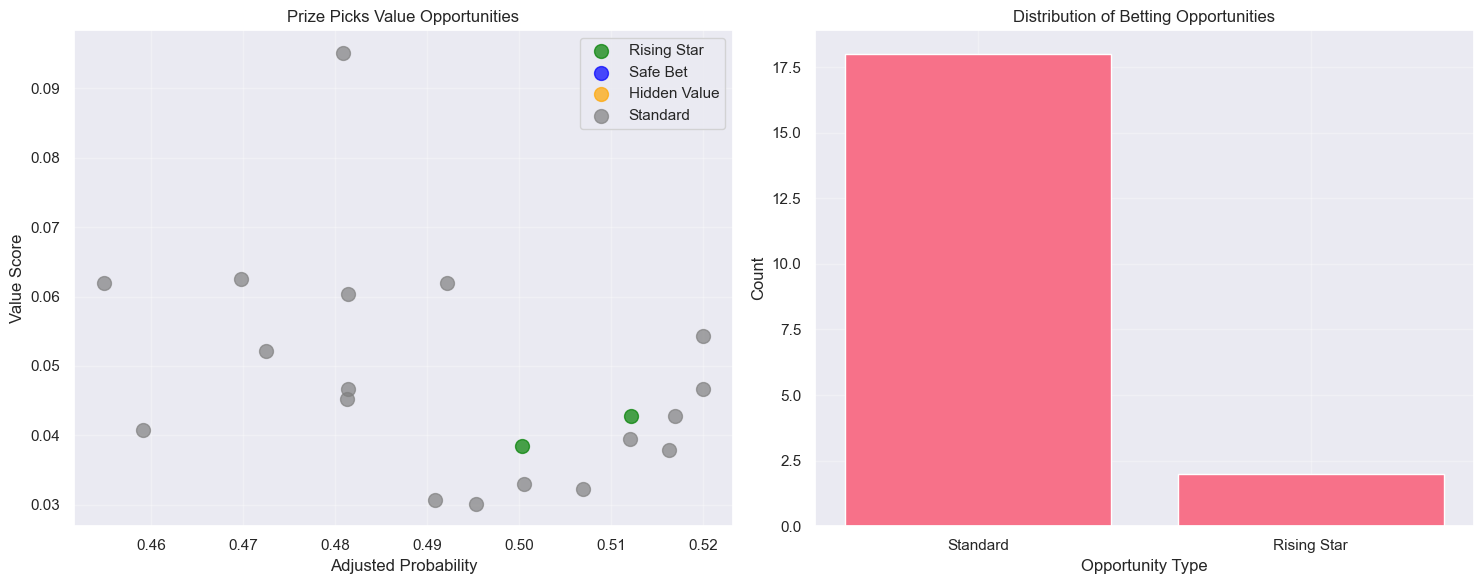


Top 10 Prize Picks Value Opportunities:
       surname  adjusted_probability  value_score opportunity_type  \
16      Kubica                 0.481        0.095         Standard   
7    Räikkönen                 0.470        0.063         Standard   
1     Hamilton                 0.455        0.062         Standard   
17    Grosjean                 0.492        0.062         Standard   
6   Hülkenberg                 0.481        0.060         Standard   
14  Giovinazzi                 0.520        0.054         Standard   
18   Ricciardo                 0.473        0.052         Standard   
3       Vettel                 0.481        0.047         Standard   
5    Magnussen                 0.520        0.047         Standard   
12       Pérez                 0.481        0.045         Standard   

   development_phase  confidence  
16         post-peak       0.611  
7          post-peak       0.590  
1          post-peak       0.741  
17         post-peak       0.561  
6          po

In [9]:
def identify_prize_picks_value(predictions, driver_metrics, development_df):
    """
    Identify high-value Prize Picks opportunities based on integrated analysis
    """
    # Merge all driver information
    value_analysis = predictions.merge(
        driver_metrics[['driverId', 'surname', 'avg_points', 'consistency_score', 'recent_form_trend']], 
        on='driverId'
    )
    value_analysis = value_analysis.merge(
        development_df[['driverId', 'development_phase']], 
        on='driverId'
    )
    
    # Calculate value scores
    value_analysis['value_score'] = (
        value_analysis['adjusted_probability'] * 
        value_analysis['consistency_score'] * 
        value_analysis['confidence']
    )
    
    # Categorize opportunities
    value_analysis['opportunity_type'] = 'Standard'
    
    # Young talent (pre-peak with good form)
    young_talent = (
        (value_analysis['development_phase'] == 'pre-peak') & 
        (value_analysis['recent_form_trend'] > 0)
    )
    value_analysis.loc[young_talent, 'opportunity_type'] = 'Rising Star'
    
    # Peak performers with high consistency
    peak_performers = (
        (value_analysis['development_phase'] == 'peak') & 
        (value_analysis['consistency_score'] > 0.7)
    )
    value_analysis.loc[peak_performers, 'opportunity_type'] = 'Safe Bet'
    
    # Value picks (good probability but potentially overlooked)
    value_picks = (
        (value_analysis['adjusted_probability'] > 0.6) & 
        (value_analysis['avg_points'] < 10)
    )
    value_analysis.loc[value_picks, 'opportunity_type'] = 'Hidden Value'
    
    # Sort by value score
    value_analysis = value_analysis.sort_values('value_score', ascending=False)
    
    # Visualize opportunities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Value vs Probability scatter
    opportunity_colors = {
        'Rising Star': 'green',
        'Safe Bet': 'blue',
        'Hidden Value': 'orange',
        'Standard': 'gray'
    }
    
    for opp_type, color in opportunity_colors.items():
        mask = value_analysis['opportunity_type'] == opp_type
        ax1.scatter(
            value_analysis[mask]['adjusted_probability'],
            value_analysis[mask]['value_score'],
            c=color, label=opp_type, alpha=0.7, s=100
        )
    
    ax1.set_xlabel('Adjusted Probability')
    ax1.set_ylabel('Value Score')
    ax1.set_title('Prize Picks Value Opportunities')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Top opportunities by type
    opportunity_counts = value_analysis['opportunity_type'].value_counts()
    ax2.bar(opportunity_counts.index, opportunity_counts.values)
    ax2.set_xlabel('Opportunity Type')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Betting Opportunities')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return value_analysis

# Create sample predictions for demonstration
sample_features = pd.DataFrame({
    'driverId': driver_metrics['driverId'].head(20),
    'grid': np.random.randint(1, 20, 20),
    'avg_position_3': np.random.uniform(5, 15, 20)
})

# Generate predictions
predictions = predictor.predict_with_evaluation(
    sample_features, 
    development_df,
    compatibility_df
)

# Identify value opportunities
value_opportunities = identify_prize_picks_value(
    predictions,
    driver_metrics,
    development_df
)

print("\nTop 10 Prize Picks Value Opportunities:")
print(value_opportunities.head(10)[[
    'surname', 'adjusted_probability', 'value_score', 
    'opportunity_type', 'development_phase', 'confidence'
]].round(3))

def generate_race_predictions(race_id=None):
    """
    Generate predictions for a specific race or upcoming race
    """
    # Get upcoming race if no race_id specified
    if race_id is None:
        # Find the most recent or next race
        races['date'] = pd.to_datetime(races['date'])
        upcoming = races[races['date'] > datetime.now()]
        if not upcoming.empty:
            race_info = upcoming.iloc[0]
            print(f"\nGenerating predictions for: {race_info['name']} ({race_info['date']})")
        else:
            print("No upcoming race found. Using most recent race.")
            recent_races = races.sort_values('date', ascending=False)
            race_info = recent_races.iloc[0]
    else:
        race_info = races[races['raceId'] == race_id].iloc[0]
    
    # Get drivers likely to participate
    # For demonstration, use top 20 active drivers
    active_drivers = driver_metrics.nlargest(20, 'races_completed')
    
    # Create race-specific features
    race_predictions = []
    
    for _, driver in active_drivers.iterrows():
        # Get driver's historical performance at this circuit
        circuit_history = df[
            (df['driverId'] == driver['driverId']) & 
            (df['circuitId'] == race_info.get('circuitId', 0))
        ]
        
        circuit_avg = circuit_history['positionOrder'].mean() if len(circuit_history) > 0 else 15
        
        # Create feature set
        features = pd.DataFrame([{
            'driverId': driver['driverId'],
            'grid': 10,  # Placeholder
            'circuit_avg': circuit_avg,
            'recent_form': driver['recent_avg_position']
        }])
        
        # Get predictions
        pred = predictor.predict_with_evaluation(
            features,
            development_df,
            compatibility_df
        )
        
        if not pred.empty:
            pred_data = pred.iloc[0]
            race_predictions.append({
                'driver': driver['surname'],
                'team': constructors[
                    constructors['constructorId'] == driver['current_constructor']
                ]['name'].iloc[0] if driver['current_constructor'] in constructors['constructorId'].values else 'Unknown',
                'top10_probability': pred_data['adjusted_probability'],
                'confidence': pred_data['confidence'],
                'age_factor': pred_data['age_factor'],
                'recent_form': driver['recent_form_trend']
            })
    
    predictions_df = pd.DataFrame(race_predictions)
    predictions_df = predictions_df.sort_values('top10_probability', ascending=False)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    y_pos = np.arange(len(predictions_df.head(15)))
    bars = ax.barh(y_pos, predictions_df.head(15)['top10_probability'])
    
    # Color by confidence using colormap directly from matplotlib.cm
    norm = Normalize(vmin=0, vmax=1)
    # Access colormap directly from cm module
    colors = cm.RdYlGn(norm(predictions_df.head(15)['confidence']))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(predictions_df.head(15)['driver'])
    ax.set_xlabel('Top 10 Probability')
    ax.set_title(f'Integrated Predictions - {race_info.get("name", "Upcoming Race")}')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add confidence indicator
    sm = cm.ScalarMappable(cmap=cm.RdYlGn, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Confidence Level')
    
    plt.tight_layout()
    plt.show()
    
    return predictions_df

# Generate predictions
race_predictions = generate_race_predictions()

print("\nTop Prize Picks Recommendations:")
print("=" * 60)
for idx, pred in race_predictions.head(5).iterrows():
    print(f"\n{pred['driver']} ({pred['team']})")
    print(f"  Top 10 Probability: {pred['top10_probability']:.1%}")
    print(f"  Confidence: {pred['confidence']:.1%}")
    print(f"  Age Factor: {pred['age_factor']:.2f}")
    print(f"  Recent Form Trend: {pred['recent_form']:+.2f}")

No upcoming race found. Using most recent race.


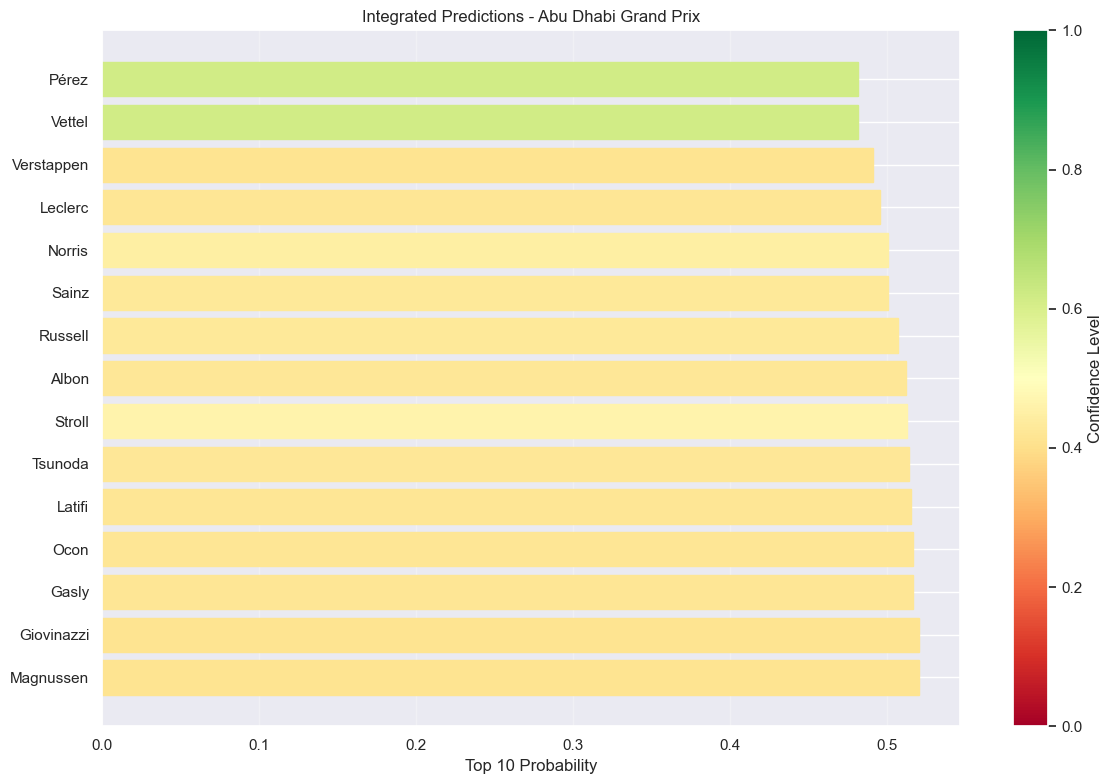


Top Prize Picks Recommendations:

Magnussen (Haas F1 Team)
  Top 10 Probability: 52.0%
  Confidence: 41.1%
  Age Factor: 1.20
  Recent Form Trend: -0.47

Giovinazzi (Alfa Romeo)
  Top 10 Probability: 52.0%
  Confidence: 41.1%
  Age Factor: 1.20
  Recent Form Trend: +0.70

Gasly (Alpine F1 Team)
  Top 10 Probability: 51.6%
  Confidence: 41.9%
  Age Factor: 1.20
  Recent Form Trend: -2.68

Ocon (Alpine F1 Team)
  Top 10 Probability: 51.6%
  Confidence: 41.9%
  Age Factor: 1.20
  Recent Form Trend: -1.15

Latifi (Williams)
  Top 10 Probability: 51.5%
  Confidence: 42.0%
  Age Factor: 1.20
  Recent Form Trend: -0.85


In [10]:
def generate_race_predictions(race_id=None):
    """
    Generate predictions for a specific race or upcoming race
    """
    # Get upcoming race if no race_id specified
    if race_id is None:
        # Find the most recent or next race
        races['date'] = pd.to_datetime(races['date'])
        upcoming = races[races['date'] > datetime.now()]
        if not upcoming.empty:
            race_info = upcoming.iloc[0]
            print(f"\nGenerating predictions for: {race_info['name']} ({race_info['date']})")
        else:
            print("No upcoming race found. Using most recent race.")
            recent_races = races.sort_values('date', ascending=False)
            race_info = recent_races.iloc[0]
    else:
        race_info = races[races['raceId'] == race_id].iloc[0]
    
    # Get drivers likely to participate
    # For demonstration, use top 20 active drivers
    active_drivers = driver_metrics.nlargest(20, 'races_completed')
    
    # Create race-specific features
    race_predictions = []
    
    for _, driver in active_drivers.iterrows():
        # Get driver's historical performance at this circuit
        circuit_history = df[
            (df['driverId'] == driver['driverId']) & 
            (df['circuitId'] == race_info.get('circuitId', 0))
        ]
        
        circuit_avg = circuit_history['positionOrder'].mean() if len(circuit_history) > 0 else 15
        
        # Create feature set
        features = pd.DataFrame([{
            'driverId': driver['driverId'],
            'grid': 10,  # Placeholder
            'circuit_avg': circuit_avg,
            'recent_form': driver['recent_avg_position']
        }])
        
        # Get predictions
        pred = predictor.predict_with_evaluation(
            features,
            development_df,
            compatibility_df
        )
        
        if not pred.empty:
            pred_data = pred.iloc[0]
            race_predictions.append({
                'driver': driver['surname'],
                'team': constructors[
                    constructors['constructorId'] == driver['current_constructor']
                ]['name'].iloc[0] if driver['current_constructor'] in constructors['constructorId'].values else 'Unknown',
                'top10_probability': pred_data['adjusted_probability'],
                'confidence': pred_data['confidence'],
                'age_factor': pred_data['age_factor'],
                'recent_form': driver['recent_form_trend']
            })
    
    predictions_df = pd.DataFrame(race_predictions)
    predictions_df = predictions_df.sort_values('top10_probability', ascending=False)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    y_pos = np.arange(len(predictions_df.head(15)))
    bars = ax.barh(y_pos, predictions_df.head(15)['top10_probability'])
    
    # Color by confidence using colormap directly from matplotlib.cm
    norm = Normalize(vmin=0, vmax=1)
    # Access colormap directly from cm module instead of plt.get_cmap
    colors = cm.RdYlGn(norm(predictions_df.head(15)['confidence']))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(predictions_df.head(15)['driver'])
    ax.set_xlabel('Top 10 Probability')
    ax.set_title(f'Integrated Predictions - {race_info.get("name", "Upcoming Race")}')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add confidence indicator
    sm = cm.ScalarMappable(cmap=cm.RdYlGn, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Confidence Level')
    
    plt.tight_layout()
    plt.show()
    
    return predictions_df

# Generate predictions
race_predictions = generate_race_predictions()

print("\nTop Prize Picks Recommendations:")
print("=" * 60)
for idx, pred in race_predictions.head(5).iterrows():
    print(f"\n{pred['driver']} ({pred['team']})")
    print(f"  Top 10 Probability: {pred['top10_probability']:.1%}")
    print(f"  Confidence: {pred['confidence']:.1%}")
    print(f"  Age Factor: {pred['age_factor']:.2f}")
    print(f"  Recent Form Trend: {pred['recent_form']:+.2f}")

## 8. Save Integrated Model

In [11]:
# Save the integrated components
integrated_model = {
    'predictor': predictor,
    'driver_metrics': driver_metrics,
    'development_scores': development_df,
    'compatibility_scores': compatibility_df,
    'age_performance': age_performance,
    'metadata': {
        'created_date': datetime.now().isoformat(),
        'n_drivers': len(driver_metrics),
        'data_range': f"{df['date'].min()} to {df['date'].max()}"
    }
}

# Save integrated model
joblib.dump(integrated_model, 'f1_integrated_evaluation_model.pkl')
print("\nIntegrated model saved successfully!")
print(f"Components: {list(integrated_model.keys())}")

# Update module exports after class is defined
__all__ = ['IntegratedF1Predictor']


Integrated model saved successfully!
Components: ['predictor', 'driver_metrics', 'development_scores', 'compatibility_scores', 'age_performance', 'metadata']


## Summary

The Integrated Driver Evaluation System combines:

1. **Fixed Prediction Models**: Properly validated models without overfitting
2. **Age-Performance Curves**: Adjust predictions based on driver development phase
3. **Constructor Compatibility**: Factor in team dynamics and fit
4. **Consistency Metrics**: Weight predictions by driver reliability
5. **Value Identification**: Find overlooked betting opportunities

### Key Insights for Prize Picks:
- **Rising Stars**: Young drivers (pre-peak) showing improvement
- **Safe Bets**: Peak-age drivers with high consistency
- **Hidden Value**: Good probability but potentially lower odds
- **Team Changes**: New driver-constructor pairings may offer value

This integrated approach provides more nuanced predictions than pure statistical models!